## Predicting Emotions of Marathon Runners from Pictures

## Overview

Facial expressions are the most effective way of non-verbal communication. It provides information about emotional state and intentions. Therefore, extracting information from facial expressions have numerous application areas. A few of the application areas are summarized below;

* **Human-Machine Interaction:** Humans and machines started to share similar tasks, so, different communication channels in between human and machines have become more important.

* **Healthcare:** Medical applications such as automatically detecting the pain level of patients in medical operations. Another application could be understanding the emotional state of people with autism spectrum disorders.

* **Market Research:** The impact of an advertiement or a comercial can be judged by showing it to a group of people and automatically detecting their emotions from their facial expressions. 

* **Security Systems:** Any intentions of criminal activities can be predicted in airports, sports arenas, casinos etc. out of the security camera images.

I am interested in long distance running and the emotional state of a runner varies a lot during running. Particularly, running long distance clears your mind from everyday psychological stressors, on the other hand, you load a more fundamental physiological stress to your body. I wanted to observe this trade-off so this notebook discusses an application of emotion detection from facial expressions: predicting emotional state of marathon runners based on their pictures.

## 1.Introduction

Facial expressions  have consistent correlation with self-reported emotion. Therefore, it is possible to predict the emotional state of people through their facial expressions. Research in psychology has indicated that six emotions are universally associated with distinct facial expressions (Ekman, 1992). These six principal emotions are: happiness, sadness, surprise, fear, anger, and disgust. Instead, here, we are going to classify the emotions into eight categories. On top of the emotions proposed by Ekman, this notebook tries to classify two more emotions; neutral and contempt. The motivation behind the eight emotions convention instead of the six emotions convention comes from the labeled dataset (AffectNet) that was acquired from the University of Denver [1]. In light of these distinct emotions, this notebook builds a neural network classifier that gets the pictures of marathon runners and a few of their demographic information and predicts their emotions. I divided the project into the following three main parts,

* Gathering the Data
* Building/Implementing the Model
* Testing the Model

The details of the implementation is discussed in the following sections.

## 2. Gathering the Data

The data for this project consists of the facial images and the demographic information of the marathon runners. The majority of the face images are acquired from University of Denver. The Electrical and Computer Engineering in University of Denver has one of the largest facial image databases (AffectNet) that consists of 420K manually labeled facial expressions. The database was around 60GB in size. After filtering the broken images and standardizing the custom size images to 128 by 128 pixels, it shrunk to ~3GB. These images are not faces of marathon runners so an additional 600 marathon runner facial expressions are labeled from 10 different marathons. The marathons are selected to be two of the biggest marathons in North America and Europe as the Chicago Marathon and London Marathon. 60 images are selected randomly among the people ranked between 1-20000 from these two marathons for each year's race from 2014 to 2018. A network is trained on the large dataset and the weights of this network is fine tuned using the small dataset together with the demographic information of the runners. More on this in the modeling part of the notebook but first I will describe the scraping process.

The demographic information was scraped from the web. Gender, age, nationality, ranking by gender and pace information was announced for each runner on the web pages of Chicago and London Marathon. An explanotary analysis was performed on the demographics information to better understand the dynamics of the problem. The scraping and the explonatory analysis are detailed below.


In [1]:
from selenium import webdriver
import pandas as pd

def chicago_mararthon_scraper():
    ## London Marathon Scraper
    driver = webdriver.Chrome(r'../chromedriver')
    demographics = {'names': [], 'gender_rank': [], 'ages': [], 'nats': [], 'rankings': [],
                    'half_times': [], 'finish_times': []}
    
    for i in range(1,216):
        driver.get('http://chicago-history.r.mikatiming.de/2014/?page='+str(i)+
                   '&event=MAR_999999107FA30900000000A1&lang=EN_CAP&num_results=100&pid=list&search%5Bsex%5D=W&search%5Bage_class%5D=%25')
        for j in range(2,102):
            row = driver.find_element_by_xpath('//*[@id="cbox-main"]/div[2]/ul/li[%s]'%j)
            demographics['rankings'].append(row.find_element_by_xpath('./div[1]/div/div[1]').text)
            demographics['names'].append(row.find_element_by_xpath('./div[1]/div/h4/a').text[:-6])
            demographics['ages'].append(row.find_element_by_xpath('./div[2]/div[1]/div/div[3]').text)
            demographics['nats'].append(row.find_element_by_xpath('./div[1]/div/h4/a').text[-4:-1])
            demographics['half_times'].append(row.find_element_by_xpath('./div[2]/div[2]/div/div[1]').text)
            demographics['finish_times'].append(row.find_element_by_xpath('./div[2]/div[2]/div/div[2]').text)
            demographics['gender_rankings'].append(row.find_element_by_xpath('./div[1]/div/div[2]').text)
    driver.quit()
    
    return demographics

#df = pd.DataFrame.from_dict(chicago_mararthon_scraper())
df = pd.read_csv('../marathon_demographics/chicago2014_jn.csv')
#df.to_csv('./chicago2014.csv')
df.head()

,rankings,names,ages,nats,half_times,finish_times,gender_rankings
0,0,"Kipchoge, Eliud",25-29,KEN,1:02:11,2:04:11,1
1,1,"Kitwara, Sammy",25-29,KEN,1:02:12,2:04:28,2
2,2,"Chumba, Dickson",25-29,KEN,1:02:12,2:04:32,3
3,3,"Bekele, Kenenisa",30-34,ETH,1:02:12,2:05:51,4
4,4,"Koech, Bernard",25-29,KEN,1:02:12,2:08:30,5


The pages that announce marathon results are dynamic web pages which show a portion of the race results (for example page shows a group of 50 or 100 finishers at a time). User needs to interact with the web page and click on buttons to see the next batch of finisher information. Selenium is a python library which helps scraping data from dynamic web sites. It allows you to open a browser of your choice and perform tasks such as clicking buttons and searching for specific information. A sample code snippet that scrapes the demographics information from 2014 Chicago Marathon is shown above. I used the XPath's of specific elements to scrape the demographics data.

The raw data needed to be cleaned and further processed. For example, the finishing times of the runners can be normalized according to the Boston Qualification time to eliminate the biases coming from age and gender for each runner. Additionally, the finishing time can be divided by the half mark passing time so that we can investigate the effect of the split times to the performance of the runners.

In [3]:
import pandas as pd
from datetime import datetime, timedelta

#Let's clean the unnecessary rows with corrupted data
chicago2014 = pd.read_csv('../marathon_demographics/chicago2014.csv').dropna()
chicago2014 = chicago2014[chicago2014['half_times'] != '–']
chicago2014 = chicago2014[chicago2014['ages'] != 'W-15']
chicago2014 = chicago2014[chicago2014['ages'] != 'M-15']


#boston qualifier dictionaries for chicago marathon
time_men_chicago = {'16-19':datetime.strptime('03:00:00', '%H:%M:%S'),
            '20-24':datetime.strptime('03:00:00', '%H:%M:%S'),
            '25-29':datetime.strptime('03:00:00', '%H:%M:%S'), 
            '30-34':datetime.strptime('03:00:00', '%H:%M:%S'),
            '35-39':datetime.strptime('03:05:00', '%H:%M:%S'),
            '40-44':datetime.strptime('03:10:00', '%H:%M:%S'),
            '45-49':datetime.strptime('03:20:00', '%H:%M:%S'),
            '50-54':datetime.strptime('03:25:00', '%H:%M:%S'),
            '55-59':datetime.strptime('03:35:00', '%H:%M:%S'),
            '60-64':datetime.strptime('03:50:00', '%H:%M:%S'),
            '65-69':datetime.strptime('04:05:00', '%H:%M:%S'),
            '70-74':datetime.strptime('04:20:00', '%H:%M:%S'),
            '75-79':datetime.strptime('04:35:00', '%H:%M:%S'),
            '80+':datetime.strptime('04:50:00', '%H:%M:%S')
            }

time_women_chicago = {'16-19':datetime.strptime('03:30:00', '%H:%M:%S'),
              '20-24':datetime.strptime('03:30:00', '%H:%M:%S'),
              '25-29':datetime.strptime('03:30:00', '%H:%M:%S'), 
              '30-34':datetime.strptime('03:30:00', '%H:%M:%S'),
              '35-39':datetime.strptime('03:35:00', '%H:%M:%S'),
              '40-44':datetime.strptime('03:40:00', '%H:%M:%S'),
              '45-49':datetime.strptime('03:50:00', '%H:%M:%S'),
              '50-54':datetime.strptime('03:55:00', '%H:%M:%S'),
              '55-59':datetime.strptime('04:05:00', '%H:%M:%S'),
              '60-64':datetime.strptime('04:20:00', '%H:%M:%S'),
              '65-69':datetime.strptime('04:35:00', '%H:%M:%S'),
              '70-74':datetime.strptime('04:50:00', '%H:%M:%S'),
              '75-79':datetime.strptime('05:05:00', '%H:%M:%S'),
              '80+':datetime.strptime('05:20:00', '%H:%M:%S')
              }


def pace(df):
    #This function returns a dataframe with 3 extra columns named, 
    #'finish_secs', 'half_secs' and 'pace'
    df['finish_secs'] = pd.to_timedelta(df['finish_times'])
    df['half_secs'] = pd.to_timedelta(df['half_times'])
    df['pace'] = (df['finish_secs'].dt.total_seconds() 
    - df['half_secs'].dt.total_seconds())/ df['half_secs'].dt.total_seconds()
    
    df = df.sort_values(['finish_secs'], ascending=[True])
    df = df.reset_index(drop=True)
    
    return df


def gender(df):
    #This function returns a dataframe with an extra column of the 
    #appropriate gender of the runner
    rankings,gender = [], []
    for i,ranking in enumerate(df['gender_rankings']):
        if ranking not in rankings:
            rankings.append(ranking)
            gender.append('M')
        else:
            gender.append('F')

    df['gender'] = gender

    return df


def bq(df, table_men, table_women):
    #This function returns a dataframe with an extra column of 'YES' and 'NO'
    #according to the boston qualification assesment
    BQ = []
    for i in range(len(df['finish_times'])):
        if df['gender'][i] == 'M':
            if df['finish_secs'][i] < timedelta(hours = table_men[df['ages'][i]].hour, minutes = table_men[df['ages'][i]].minute, seconds = table_men[df['ages'][i]].second):
                BQ.append('YES')
            else: BQ.append('NO')
        elif df['gender'][i] == 'F':
            if df['finish_secs'][i] < timedelta(hours = table_women[df['ages'][i]].hour, minutes = table_women[df['ages'][i]].minute, seconds = table_women[df['ages'][i]].second):
                BQ.append('YES')
            else: BQ.append('NO')

    df['BQ'] = BQ   
    
    return df

#chicago2014 = bq(gender(pace(chicago2014)), time_men_chicago, time_women_chicago)
df = pd.read_csv('../marathon_demographics/chicago2014.csv')
#chicago2014.to_csv('./chicago2014_clean.csv')
df.head()

,rankings,names,ages,nats,half_times,finish_times,gender_rankings,finish_secs,half_secs,pace,gender,BQ
0,0,"Kipchoge, Eliud",25-29,KEN,1:02:11,2:04:11,1,0 days 02:04:11.000000000,0 days 01:02:11.000000000,0.997052,M,YES
1,1,"Kitwara, Sammy",25-29,KEN,1:02:12,2:04:28,2,0 days 02:04:28.000000000,0 days 01:02:12.000000000,1.001072,M,YES
2,2,"Chumba, Dickson",25-29,KEN,1:02:12,2:04:32,3,0 days 02:04:32.000000000,0 days 01:02:12.000000000,1.002144,M,YES
3,3,"Bekele, Kenenisa",30-34,ETH,1:02:12,2:05:51,4,0 days 02:05:51.000000000,0 days 01:02:12.000000000,1.023312,M,YES
4,4,"Koech, Bernard",25-29,KEN,1:02:12,2:08:30,5,0 days 02:08:30.000000000,0 days 01:02:12.000000000,1.065916,M,YES


Once the data is cleaned and additional features are added for training, 600 runner images are picked at random and labeled based on their emotions. Now, the data frame is ready for the exploratory analysis.

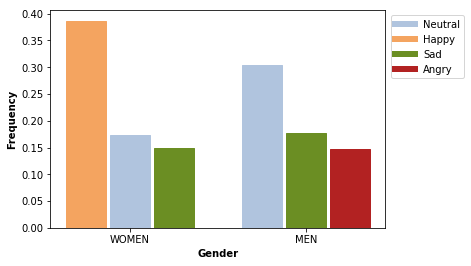

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline

chicago = pd.read_csv('../marathon_demographics/chicago2018.csv').dropna()
london = pd.read_csv('../marathon_demographics/london2018.csv').dropna()

gender = (london.groupby(['gender','emotions'])['names'].count() + 
          chicago.groupby(['gender','emotions'])['names'].count()).reset_index()
gender.rename(columns={'names': 'count'}, inplace=True)

gender.loc[gender['gender']=='M', 'frequency'] = gender.loc[gender['gender']=='M', 
           'count'] / gender.loc[gender['gender'] == 'M','count'].sum()
gender.loc[gender['gender']=='F', 'frequency'] = gender.loc[gender['gender']=='F', 
           'count'] / gender.loc[gender['gender'] == 'F','count'].sum()

gender = gender.sort_values(['gender','frequency'], ascending=[True,False])


# set width of bar
barWidth = 0.23
 
# set height of bar
women = list(gender.loc[:2,'frequency'])
men = list(gender.loc[7:13,'frequency'])

# Set position of bar on X axis
y1 = [0.25,0.5,0.75]
y2 = [1.25,1.5,1.75]
 
# Make the plot
set1 = plt.bar(y1, women, width=barWidth)
set2 = plt.bar(y2, men, width=barWidth)

set1[0].set_color('sandybrown')
set1[1].set_color('lightsteelblue')
set1[2].set_color('olivedrab')

set2[0].set_color('lightsteelblue')
set2[1].set_color('olivedrab')
set2[2].set_color('firebrick')

# Add xticks on the middle of the group bars
plt.xlabel('Gender', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.xticks([r + 0.5 for r in range(2)], ['WOMEN', 'MEN'])
plt.gca().xaxis.grid(False)

legend_elements = [Line2D([0], [0], color='lightsteelblue', lw=6, label='Neutral'),
                   Line2D([0], [0], color='sandybrown', lw=6, label='Happy'),
                   Line2D([0], [0], color='olivedrab', lw=6, label='Sad'),
                   Line2D([0], [0], color='firebrick', lw=6, label='Angry')]
# Create legend & Show graphic
plt.legend(handles=legend_elements,bbox_to_anchor=(1.25, 1.0))
#plt.savefig('gender.eps',dpsi=1000)

Plot above shows three common emotions based on gender. We see that women express mostly a happy face whereas men have negative emotions such as sadness and anger. We might speculate here that women has higher pain tolerance than men.

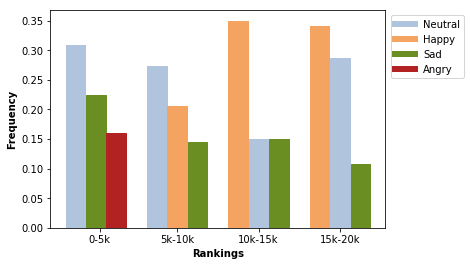

In [11]:
#####-------------------ranking analysis-----------------------------###
sizeBins = [0, 5000, 10000, 15000, 20050]
chicago['binned_rankings'] = pd.cut(chicago['pic_num'], bins = sizeBins)
london['binned_rankings'] = pd.cut(london['pic_num'], bins = sizeBins)

rankings = (london.groupby(['binned_rankings','emotions'])['names'].count() + 
          chicago.groupby(['binned_rankings','emotions'])['names'].count()).reset_index()
rankings.rename(columns={'names': 'count'}, inplace=True)
rankings = rankings.dropna()
rankings['binned_rankings'] = rankings['binned_rankings'].apply(lambda x:x.right)

rankings.loc[rankings['binned_rankings']==5000, 'frequency'] = rankings.loc[
        rankings['binned_rankings']==5000,'count']/rankings.loc[rankings[
                'binned_rankings']==5000,'count'].sum()

rankings.loc[rankings['binned_rankings']==10000, 'frequency'] = rankings.loc[
        rankings['binned_rankings']==10000,'count']/rankings.loc[rankings[
                'binned_rankings']==10000,'count'].sum()

rankings.loc[rankings['binned_rankings']==15000, 'frequency'] = rankings.loc[
        rankings['binned_rankings']==15000,'count']/rankings.loc[rankings[
                'binned_rankings']==15000,'count'].sum()

rankings.loc[rankings['binned_rankings']==20050, 'frequency'] = rankings.loc[
        rankings['binned_rankings']==20050,'count']/rankings.loc[rankings[
                'binned_rankings']==20050,'count'].sum()

rankings = rankings.sort_values(['binned_rankings', 'frequency'], ascending=[True, False])

## set width of bar
barWidth = 0.24
 
# set height of bar
bin1 = list(rankings.loc[:6,'frequency'])
bin2 = list(rankings.loc[8:10,'frequency'])
bin3 = list(rankings.loc[17:18,'frequency'])
bin4 = list(rankings.loc[23:24,'frequency'])

# Set position of bar on X axis
y1 = [0.1,0.35,0.6]
y2 = [1.1,1.35,1.6]
y3 = [2.1,2.35,2.6]
y4 = [3.1,3.35,3.6]
#
# Make the plot
set1 = plt.bar(y1, bin1, width=barWidth, edgecolor='white')
set2 = plt.bar(y2, bin2, width=barWidth, edgecolor='white')
set3 = plt.bar(y3, bin3, width=barWidth, edgecolor='white')
set4 = plt.bar(y4, bin4, width=barWidth, edgecolor='white')

set1[0].set_color('lightsteelblue')
set1[1].set_color('olivedrab')
set1[2].set_color('firebrick')

set2[0].set_color('lightsteelblue')
set2[1].set_color('sandybrown')
set2[2].set_color('olivedrab')

set3[0].set_color('sandybrown')
set3[1].set_color('lightsteelblue')
set3[2].set_color('olivedrab')

set4[0].set_color('sandybrown')
set4[1].set_color('lightsteelblue')
set4[2].set_color('olivedrab')

# Add xticks on the middle of the group bars
plt.xlabel('Rankings', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.xticks([r + 0.4 for r in [0,0.95,1.95,2.95]], ['0-5k', '5k-10k','10k-15k','15k-20k'])
plt.gca().xaxis.grid(False)

legend_elements = [Line2D([0], [0], color='lightsteelblue', lw=6, label='Neutral'),
                   Line2D([0], [0], color='sandybrown', lw=6, label='Happy'),
                   Line2D([0], [0], color='olivedrab', lw=6, label='Sad'),
                   Line2D([0], [0], color='firebrick', lw=6, label='Angry')]
# Create legend & Show graphic
plt.legend(handles=legend_elements,bbox_to_anchor=(1.25, 1.0))
#plt.savefig('rankings.eps',dpsi=1000)

Plot above shows the finishing places of people binned by 5k increments and colors represent top three common emotions. It is interesting that people who ranked in the first 5k places had mostly negative emotions such as sadness and anger, whereas when you go down in the rankings you realize people start to feel happier. Top finishers probably invested a lot by running more than 50 miles a week and they are more ambitious and concentrated than the 15-20k window. This might be the reason that they express serious faces compared to the slower pace runners.



## 3. Implementing and Testing the Model

The emotional state of the marathon runners are predicted according to the following analysis;
* A convolutional neural network was constructed highly similar to an AlexNet architecture. I did not want to make it too deep because first, I did not have the resources to train a deep network, second, it would take weeks to train a network similar to an Inception or a ResNet. Also, I did not want it to be a short one like a LeNet as I would want to distinguish enough features to make reasonable predictions so AlexNet looked like to be the best choice.
* A convolutional neural network (I called it the vision network in the code and in the rest of the discussion) was trained with the labeled facial expressions (AffectNet) acquired from University of Denver and weights were saved. This dataset had 420K expressions and the training was done one a single GPU (Tesla K80) for 6 hours.
* A parallel artificial neural network was constructed with three layers to train the demographics dataset. This dataset is merged with the vision network to take into account both the facial expressions and the correlations coming from the demographics described above in the exploratory analysis.
* Then, this bilinear network was trained by keeping the majority of the vision network's weights frozen with the actual marathon images and demographics. In other words, I fine tuned the vision network while training the artificial neural network.

The architecture of the bilinear network can be seen below,

![alt info](bilinear_net.png)

The network outputs the probabilities of each emotion but the prediction layer does a one vs all classification so all probabilities do not add up to 1. As emotional state is a continuous spectrum and there are no distinct lines in between different emotions, depending on the application top emotion or top a few emotions can be reported.

All the code snippets together with the weights for the project are kept in this repository, I am just going to briefly discuss the hyperparamter tuning process by showing the loss and accuracy with respect to the 30 epochs of training. The network was initially overfitting so I ended up increasing the regularization and dropout ratios after the convolutional layers to fix it. The test set accuracy of this model ended up being 69-72% based on a few experiments with the same hyperparameters. The general training behavior of the vision model is displayed below.

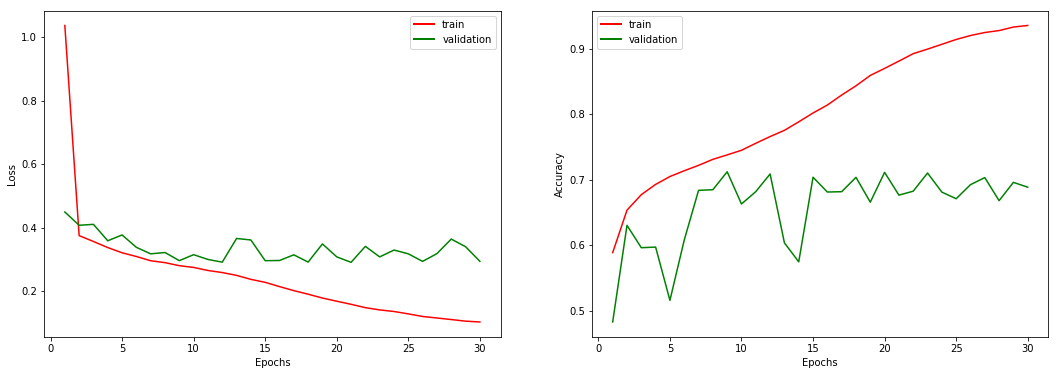

In [12]:
import pickle

with open('weights/train_history_v7', 'rb') as f:
    data_v7 = pickle.load(f, encoding='latin1')
epochs = range(1,31)

fig, axes = plt.subplots(1, 2, figsize=(18,6))
custom_lines = [Line2D([0], [0], color='red', lw=2),
                Line2D([0], [0], color='green', lw=2)]

axes[0].plot(epochs, data_v7['loss'], 'r-', epochs, data_v7['val_loss'], 'g-')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epochs')
axes[0].legend('Label via method')
axes[0].legend(custom_lines, ['train', 'validation'])

axes[1].plot(epochs, data_v7['categorical_accuracy'], 'r-', epochs, data_v7['val_categorical_accuracy'], 'g-')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].legend(custom_lines, ['train', 'validation'])

plt.show()

After saving the weights of the vision network, the bilinear network was trained on top of it with my CPU for 30 epochs with 600 samples. The performance of the combined network increased significantly once the demographics information was added to the model. The test accuracy increased to 87-88%.

In [14]:
from helper_functions import freeze_layers, \
                            data_shuffler, test_cv_train_division, \
                            marathon_image_from_csv, get_demographics
from combined_network import bilinear_network

def bilinear_main():
    #let's first set the hyperparameters and prepare the 
    #images and demographics information for training
    batch_size, epochs, num_classes, input_size, train_split, cv_split, tot_data_size = 128, 30, 8, 128, 0.9, 0.2, 601
    all_images, all_labels = marathon_image_from_csv(input_size, tot_data_size)
    demographics_x = get_demographics()
    
    
    #Shuffling and didviding the data into train, cv and test sets
    all_images, all_labels, demographics_x = data_shuffler(all_images, all_labels, demographics_x)
    x_vision_train, x_vision_test, y_train, y_test = test_cv_train_division(all_images, all_labels, train_split, tot_data_size)
    x_dem_train, x_dem_test, y_train, y_test = test_cv_train_division(demographics_x, all_labels, train_split, tot_data_size)
    
    
    #call the bilinear network for fine tuning the vision 
    #network and training the ann for demographics network
    model = bilinear_network(num_classes, len(demographics_x[0]))
    
    #freezes layers until the given layer
    model = freeze_layers(model, 'fc1')
    
    fit = True
    if fit == True:
        history = model.fit([x_dem_train, x_vision_train], y_train, validation_split = cv_split, epochs=epochs, batch_size=batch_size)
        model_json = model.to_json()
        with open("weights/combined_model.json", "w") as json_file:
            json_file.write(model_json)
        with open('weights/combined_train_history', 'wb') as file_pi:
            pickle.dump(history.history, file_pi)
        model.save_weights('weights/combined_model.h5')
    else:
        model.load_weights('weights/combined_model.h5') #load weights

    test_score = model.evaluate([x_dem_test, x_vision_test], y_test, verbose=0)
    probs = model.predict([x_dem_test, x_vision_test])
    print('Test Loss:', test_score[0])
    print('Test Accuracy:', 100*test_score[1])
    
    return probs, y_test
    
if __name__ == '__main__':
    probs, y_test = bilinear_main()

Train on 432 samples, validate on 108 samples
Epoch 1/30
432/432 [==============================] - 24s 56ms/step - loss: 0.7447 - acc: 0.5587 - val_loss: 0.7455 - val_acc: 0.5475
Epoch 2/30
432/432 [==============================] - 15s 34ms/step - loss: 0.7441 - acc: 0.5660 - val_loss: 0.7445 - val_acc: 0.5775
Epoch 3/30
432/432 [==============================] - 15s 35ms/step - loss: 0.7427 - acc: 0.6039 - val_loss: 0.7429 - val_acc: 0.6123
Epoch 4/30
432/432 [==============================] - 15s 35ms/step - loss: 0.7409 - acc: 0.6400 - val_loss: 0.7410 - val_acc: 0.6435
Epoch 5/30
432/432 [==============================] - 15s 35ms/step - loss: 0.7390 - acc: 0.6765 - val_loss: 0.7391 - val_acc: 0.6806
Epoch 6/30
432/432 [==============================] - 15s 34ms/step - loss: 0.7369 - acc: 0.7144 - val_loss: 0.7370 - val_acc: 0.7118
Epoch 7/30
432/432 [==============================] - 15s 34ms/step - loss: 0.7349 - acc: 0.7523 - val_loss: 0.7348 - val_acc: 0.7303
Epoch 8/30
432/4

The loss and accuracy of the combined network is shown below.

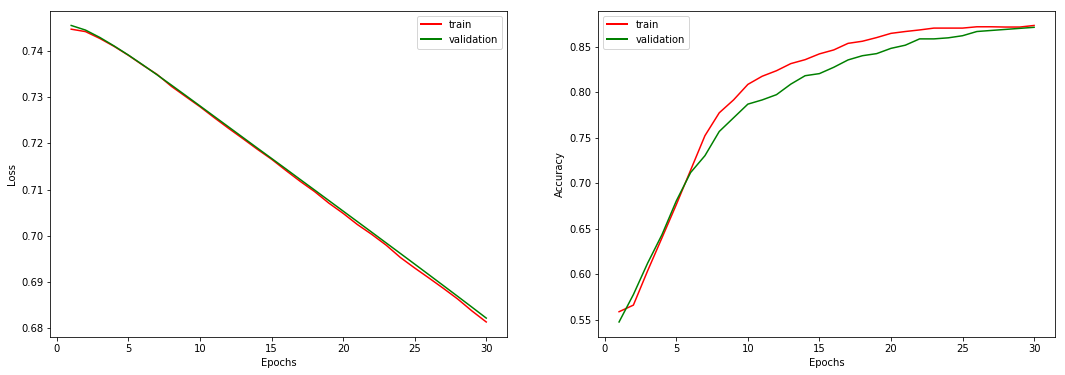

In [15]:
import pickle

with open('weights/combined_train_history', 'rb') as f:
    data = pickle.load(f, encoding='latin1')
epochs = range(1,31)

fig, axes = plt.subplots(1, 2, figsize=(18,6))
custom_lines = [Line2D([0], [0], color='red', lw=2),
                Line2D([0], [0], color='green', lw=2)]

axes[0].plot(epochs, data['loss'], 'r-', epochs, data['val_loss'], 'g-')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epochs')
axes[0].legend('Label via method')
axes[0].legend(custom_lines, ['train', 'validation'])

axes[1].plot(epochs, data['acc'], 'r-', epochs, data['val_acc'], 'g-')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].legend(custom_lines, ['train', 'validation'])

plt.show()

In [16]:
#let's do a quick demonstration of the model
from PIL import Image
from vision_network import network
import numpy as np

model = network(8, 128) #inputing the number of classes and the pixel size of the pictures
model.load_weights('weights/model_weights_v7.h5') #load weights
img = Image.open('test_image.png')
im_test = np.array(img)
im_test = np.expand_dims(im_test, axis=0)

probs = model.predict(im_test[:,:,:,:3])

![alt info](test_image.png)

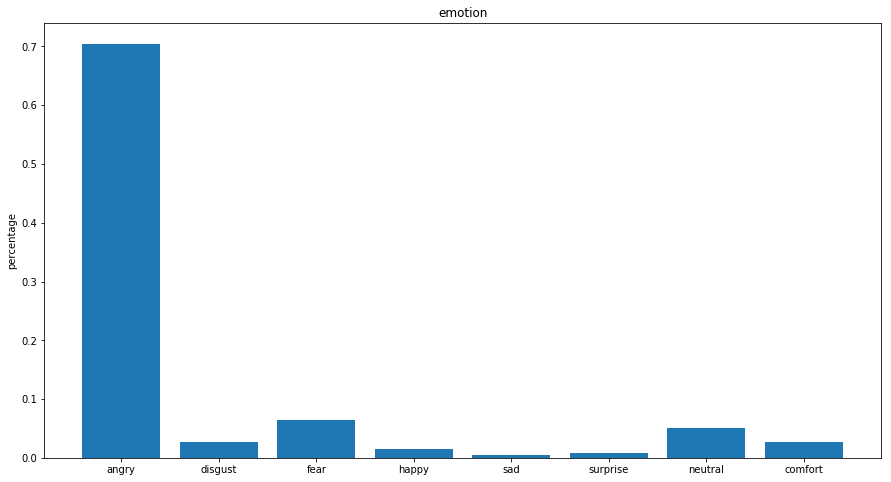

In [17]:
objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral', 'comfort')
y_pos = np.arange(len(objects))
fig= plt.figure(figsize=(15,8))
plt.bar(y_pos, probs[0], align='center')
plt.xticks(y_pos, objects)
plt.ylabel('percentage')
plt.title('emotion')
plt.show()

## 4. Conclusion

This notebook describes the data gathering and modeling process of an emotion detection problem for marathon runners. The data consists of labeled facial expressions and a few demographic information. Finally, the network that only works on facial expressions reached a test set accuracy of ~70%. This is the accuracy for the top emotion but depending on the application a few emotions can also be outputed from the network. Also, once the demographics information was added to the model, accuracy of the predictions increased to ~87%. A web application of this project can be found here: https://nostradamusproject.herokuapp.com/